In [3]:
#import libraries for normalizing and analyzing data
from sklearn.preprocessing import StandardScaler
import pandas as pd

#import libraries for visualizing insights
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#ingest .csv data file
df = pd.read_csv("C:/Users/helen/OneDrive/Desktop/league_data_clean.csv")

# League of Legends Champion Performance Analysis
## Main Objective
Based on champion performance metrics for League of Legends patch 12.23, identify the Top 5 champions to prioritize for either buffs or nerfs going into the next patch with the goal of creating a more balanced and enjoyable experience for players.

When there is too much variance in the performance of certain champions compared to the average champion, player experience suffers. It's not fun to play against champions that are too strong, and it's also not fun if your favorite champion feels too weak.

### Step 1
Normalize champion performance data using z-scores to identify true statistical outliers based on distribution. My hypothesis is that the champions whose performance metrics differ the most from the average/mean are the champions that are most in need of balance attention.

The reason why I want to use z-score standardization for outliers rather than interquartile range (IQR) is because I care about how far a champion's performance metrics are from the statistical average, not about how a champion's performance metrics rank relative to other champions. For example, the IQR method might be able to tell me the top and bottom 5% of performers, but I wouldn't want to recommend adjusting a champion who ends up in the top 5% but has metrics that do not vary greatly from the average.

In [5]:
#df contains data on champion performances in patch 12.23 that has already been transformed for the purposes of analysis

#calculate z-scores
#metrics to analyze: winrate, pickrate, banpercentage
to_scale = ['WRate', 'PickRate', 'BanPerc']
scaler = StandardScaler()

#standardize metrics
z_scores = scaler.fit_transform(df[to_scale])

#add z-scores to df
df[['WRate_z', 'PickRate_z', 'BanPerc_z']] = z_scores

Now that I have normalized the data that I want to use for identifying outlier champions, I can visualize the distributions.

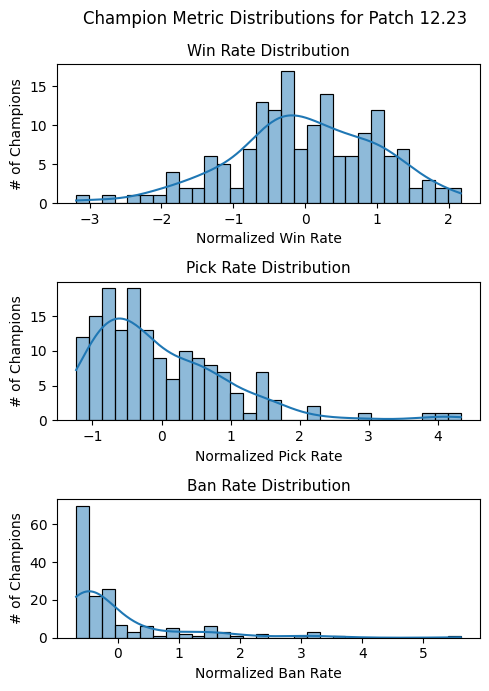

In [6]:
#set up visualization
fig = plt.figure(figsize = (5, 7))
st = fig.suptitle("Champion Metric Distributions for Patch 12.23", x = 0.56)

#visualize WRate distribution
plt1 = fig.add_subplot(3, 1, 1)
sns.histplot(data=df, x='WRate_z', bins=30, kde=True)
plt1.set_title('Win Rate Distribution', fontsize = 11)
plt1.set_xlabel('Normalized Win Rate')
plt1.set_ylabel('# of Champions')

#visualize PickRate distribution
plt2 = fig.add_subplot(3, 1, 2)
sns.histplot(data=df, x='PickRate_z', bins=30, kde=True)
plt2.set_title('Pick Rate Distribution', fontsize = 11)
plt2.set_xlabel('Normalized Pick Rate')
plt2.set_ylabel('# of Champions')

#visualize BanPerc distribution
plt3 = fig.add_subplot(3, 1, 3)
sns.histplot(data=df, x='BanPerc_z', bins=30, kde=True)
plt3.set_title('Ban Rate Distribution', fontsize = 11)
plt3.set_xlabel('Normalized Ban Rate')
plt3.set_ylabel('# of Champions')

plt.tight_layout()
plt.show()

### Step 2
From the histogram graphs, it's easy to see that there are significant outliers for all three performance metrics. I now want to identify which champions are significantly outperforming or underperforming in one or more of these metrics in order to find the best candidates for balancing (the champions that are most in need of immediate attention).

Based on where outliers seem to be from the histograms, I will use z-scores of -2 and 2 as the thresholds for outliers in this analysis.

In [7]:
#instantiate dataframe that tracks whether champions are outliers for the three performance metrics
if_outlier = df[['WRate_z', 'PickRate_z', 'BanPerc_z']].abs() > 2

#to find which champions are most in need of balancing, need to see what champions are considered outliers in one or more metrics
#add the count of how many metrics a champion is an outlier in to the original df
df['Count'] = if_outlier.sum(axis=1)

In [8]:
#show all champions who are outliers for 2 or more metrics along with their actual metrics
t_outliers = df[df['Count'] >= 1]
print(t_outliers)

         Name                 ValidRoles  PopRole  WRate  PickRate  RolePerc  \
0      Aatrox                        TOP      TOP  51.21     10.73     89.92   
2       Akali                 TOP,MIDDLE   MIDDLE  47.73      8.39     73.87   
8    Aphelios                     BOTTOM   BOTTOM  46.10      4.42     98.03   
11       Azir                     MIDDLE   MIDDLE  47.47      2.43     87.60   
17    Caitlyn                     BOTTOM   BOTTOM  51.61     18.99     98.24   
22     Darius                        TOP      TOP  51.87      8.43     92.08   
29     Ezreal                     BOTTOM   BOTTOM  49.06     20.05     96.21   
31      Fiora                        TOP      TOP  53.03      9.28     97.31   
40    Hecarim                     JUNGLE   JUNGLE  49.89      7.54     98.14   
49       Jhin                     BOTTOM   BOTTOM  52.42     15.64     94.94   
52     Kai'Sa                     BOTTOM   BOTTOM  51.84     20.77     97.22   
75     Maokai             SUPPORT,JUNGLE

### Step 3
Now that we have a list of 19 outlier champions, we can analyze which 5 champions actually should be prioritized for buffs or nerfs.

Before we figure that out, though, it's important to note that:
1. There is only 1 champion who is an outlier in 2 performance metrics
2. There are 0 champions who are outliers in 3 performance metrics

Based on this, it's fair to assume that the champions are actually quite balanced in this patch and **there may not need to be any significant balancing tweaks** made at all, especially considering that the champion with 2 outlier metrics is Zed, who is expected to be an outlier for ban rate especially in lower elos and that isn't a cause for concern.

To begin paring down the data, I want to remove all champions who are not outliers in terms of win rate.

My hypothesis is that win rate is the most objective indicator of champion balance when it comes to this set of performance metrics, since both pick rate and ban rate can fluctuate based on subjective factors like player sentiment or bias (for example, Zed is banned by a large percentage of lower elo players due to popular perception that he is difficult to play against, which is based more on understanding and skill rather than fact).

In [9]:
#drop rows where the absolute value of WRate_z is less than 2
t_outliers = t_outliers.drop(t_outliers[t_outliers.WRate_z.abs() < 2].index)
print(t_outliers)

         Name                 ValidRoles  PopRole  WRate  PickRate  RolePerc  \
2       Akali                 TOP,MIDDLE   MIDDLE  47.73      8.39     73.87   
8    Aphelios                     BOTTOM   BOTTOM  46.10      4.42     98.03   
11       Azir                     MIDDLE   MIDDLE  47.47      2.43     87.60   
75     Maokai             SUPPORT,JUNGLE   JUNGLE  54.68      2.01     42.61   
90   Pantheon  TOP,SUPPORT,JUNGLE,MIDDLE  SUPPORT  46.70      2.15     34.66   
140        Vi                     JUNGLE   JUNGLE  54.66      4.19     94.08   

     BanPerc   WRate_z  PickRate_z  BanPerc_z  Count  
2      15.25 -2.170484    0.897940   1.189365      1  
8       0.60 -3.187572   -0.203792  -0.623204      1  
11      0.62 -2.332719   -0.756046  -0.620730      1  
75      0.92  2.166182   -0.872602  -0.583612      1  
90      0.99 -2.813184   -0.833750  -0.574952      1  
140     0.82  2.153702   -0.267620  -0.595985      1  


This brings us down to 6 champions. In a real business situation, I would present all 6 of these champions as potential candidates for balance changes and defer to the game design team to decide which, if any, of these champions actually need attention, since only the design team will know if these metrics actually fall outside of expected values.

But for the sake of this exercise, since the problem statement asks for 5 champions, I will defer back to using win rate as the most objective metric and remove the champion who is the least deviated from the mean.

In [10]:
#drop the champion whose win rate is least deviated from the mean
t_outliers = t_outliers.drop(t_outliers['WRate_z'].abs().idxmin())
print(t_outliers)

        Name                 ValidRoles  PopRole  WRate  PickRate  RolePerc  \
2      Akali                 TOP,MIDDLE   MIDDLE  47.73      8.39     73.87   
8   Aphelios                     BOTTOM   BOTTOM  46.10      4.42     98.03   
11      Azir                     MIDDLE   MIDDLE  47.47      2.43     87.60   
75    Maokai             SUPPORT,JUNGLE   JUNGLE  54.68      2.01     42.61   
90  Pantheon  TOP,SUPPORT,JUNGLE,MIDDLE  SUPPORT  46.70      2.15     34.66   

    BanPerc   WRate_z  PickRate_z  BanPerc_z  Count  
2     15.25 -2.170484    0.897940   1.189365      1  
8      0.60 -3.187572   -0.203792  -0.623204      1  
11     0.62 -2.332719   -0.756046  -0.620730      1  
75     0.92  2.166182   -0.872602  -0.583612      1  
90     0.99 -2.813184   -0.833750  -0.574952      1  


Now, I want to visualize the data for these champions in a way that might be helpful to the game design team when they decide who to buff or nerf.

In [39]:
#visualize the roles that these champions are being measured for, the percentage of games where they are played in for that role, and other roles that they are commonly played in

#to do that easily, need to transform the data a little
#define function to create a new column containing all unpopular but valid champion roles
def dedup(row):
    val_values = set()
    pop_values = set()
    for col in ['ValidRoles']:
        val_values.update([x.strip() for x in row[col].split(',')])
    for col in ['PopRole']:
        pop_values.update([x.strip() for x in row[col].split(',')])
    diff = val_values - pop_values
    return ', '.join((diff))

df['OffRoles'] = df.apply(dedup, axis=1)

#also want to create a new column that contains the percentage of time when a champion is played off-role
def perc_calc(row):
    hundred = 100.0;
    val = hundred - row['RolePerc'];
    return val
    
df['OffRolePerc'] = df.apply(perc_calc, axis=1)

In [ ]:
#use new columns to visualize each of the 5 buff/nerf candidates' roles and role percentages
#set up visualization
fig = plt.figure(figsize = (5, 7))
st = fig.suptitle("Play Stats for Buff/Nerf Candidates in Patch 12.23", x = 0.56)

plt1 = fig.add_subplot(3, 3, 1)
plt1.pie(

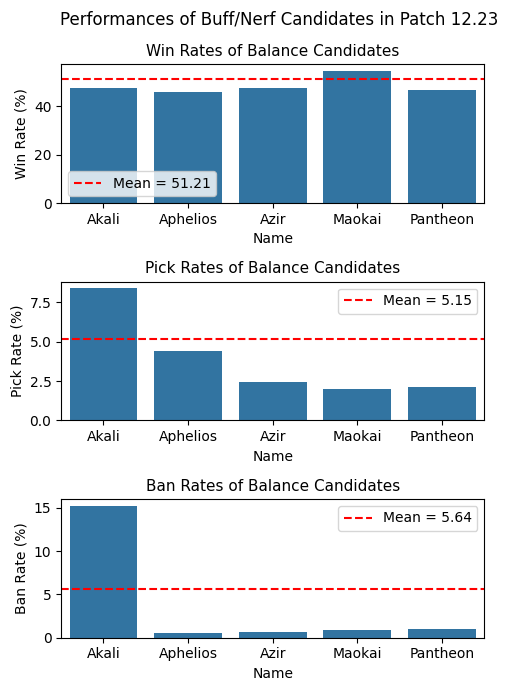

In [29]:
#visualize these champions' metrics compared to the overall mean
#set up visualization
fig = plt.figure(figsize = (5, 7))
st = fig.suptitle("Performances of Buff/Nerf Candidates in Patch 12.23", x = 0.56)

#instantiating values for the means
wrate_m = df['WRate'].mean()
prate_m = df['PickRate'].mean()
brate_m = df['BanPerc'].mean()

#visualize outliers win rates
plt1 = fig.add_subplot(3, 1, 1)
sns.barplot(data=t_outliers, x='Name', y='WRate')
plt1.axhline(wrate_m, color='red', linestyle='--', label=f'Mean = {wrate_m:.2f}')
plt1.set_title('Win Rates of Balance Candidates', fontsize = 11)
plt1.set_ylabel('Win Rate (%)')
plt1.legend()

#visualize outliers pick rates
plt2 = fig.add_subplot(3, 1, 2)
sns.barplot(data=t_outliers, x='Name', y='PickRate')
plt2.axhline(prate_m, color='red', linestyle='--', label=f'Mean = {prate_m:.2f}')
plt2.set_title('Pick Rates of Balance Candidates', fontsize = 11)
plt2.set_ylabel('Pick Rate (%)')
plt2.legend()

#visualize outliers ban rates
plt3 = fig.add_subplot(3, 1, 3)
sns.barplot(data=t_outliers, x='Name', y='BanPerc')
plt3.axhline(brate_m, color='red', linestyle='--', label=f'Mean = {brate_m:.2f}')
plt3.set_title('Ban Rates of Balance Candidates', fontsize = 11)
plt3.set_ylabel('Ban Rate (%)')
plt3.legend()

plt.tight_layout()
plt.show()

## Next Steps

The results from this exercise are not perfect and in an ideal world, there are a few other data points I would want to take into consideration.

In [23]:
df.dtypes

Name           object
ValidRoles     object
PopRole        object
WRate         float64
PickRate      float64
RolePerc      float64
BanPerc       float64
WRate_z       float64
PickRate_z    float64
BanPerc_z     float64
Count           int64
AllRoles       object
dtype: object